# Constructor-based GAM Demo

This notebook demonstrates the new formula-based Constructor interface for building GAMs with liesel_gam.

## Setup and Imports

In [1]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as lgam

In [2]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

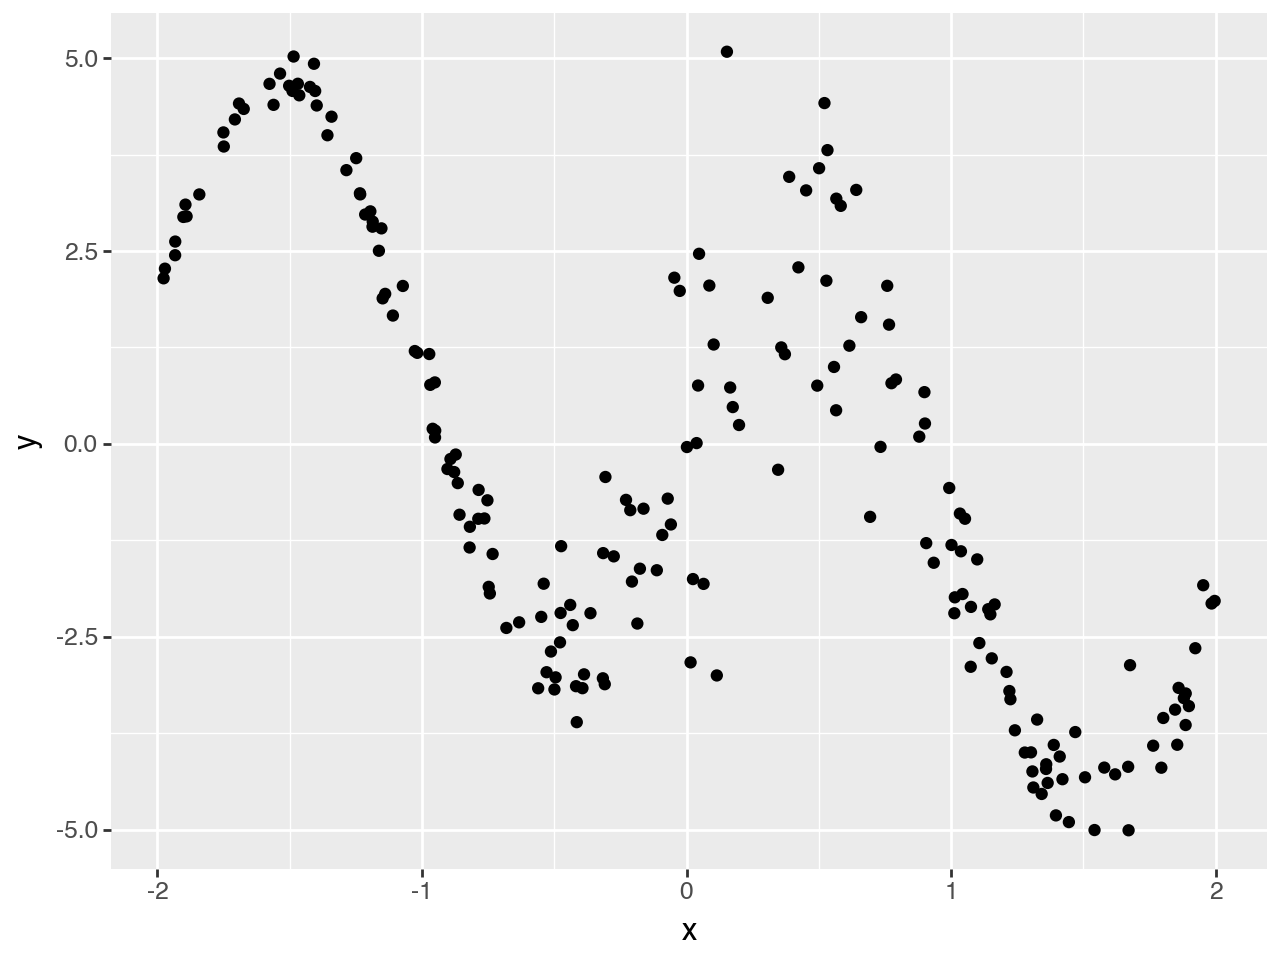

In [3]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Constructor-based Model Definition

The Constructor provides R-like formula syntax for building GAMs:
- Intercept control: `1` (include) or `0` (exclude)
- Linear effects: `x1 + x2`
- `s()` terms use R's mgcv package via smoothcon (requires R installation)  
- `ls()` terms use liesel's native P-splines implementation
- `custom()` terms are allowed for custom functions registered when initiating the constructor.

Here we build a distributional GAM with smooth effects on both location and scale parameters.

In [4]:
constructor = lgam.Constructor(df)


loc = constructor.predictor("s(x)", name="$\\mu$")
scale = constructor.predictor("s(x)", name="$\\sigma$", inv_link=jnp.exp)
y = constructor.response("y", distribution=tfd.Normal, loc=loc, scale=scale)
model = lsl.Model([y])

liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="x_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value


Here we build a distributional GAM with smooth effects on both location and scale parameters. The Constructor uses semantic naming with predictor prefixes (e.g., `mu_s(x)`, `sigma_s(x)`).

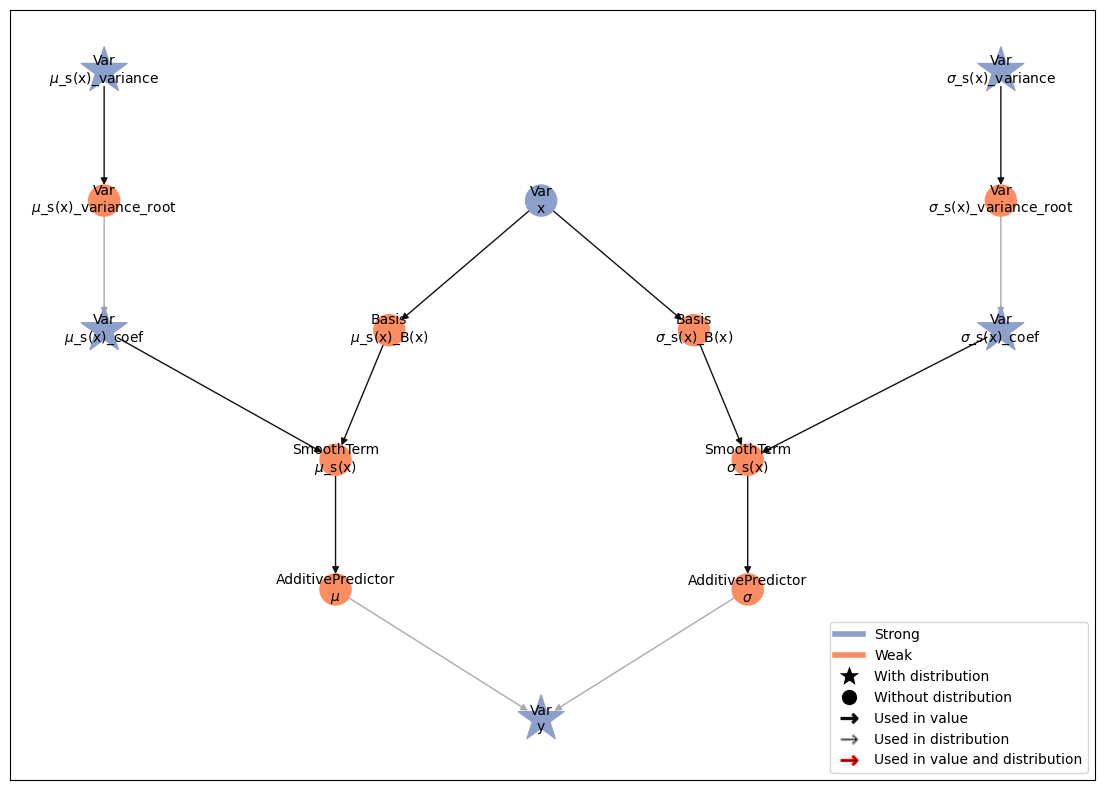

In [5]:
model.plot_vars()

### Custom Term Naming

The Constructor supports custom naming for better interpretability. Using `constructor.get_term_keys("x1 + x3 + s(x2) + ls(x4)")`, we can retrieve the term keys for the predictor. These can be used to overwrite them with semantic names. We do this examplarily here for the smooth effect on the location parameter.

liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="x_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value


Available term keys: ['s(x)']


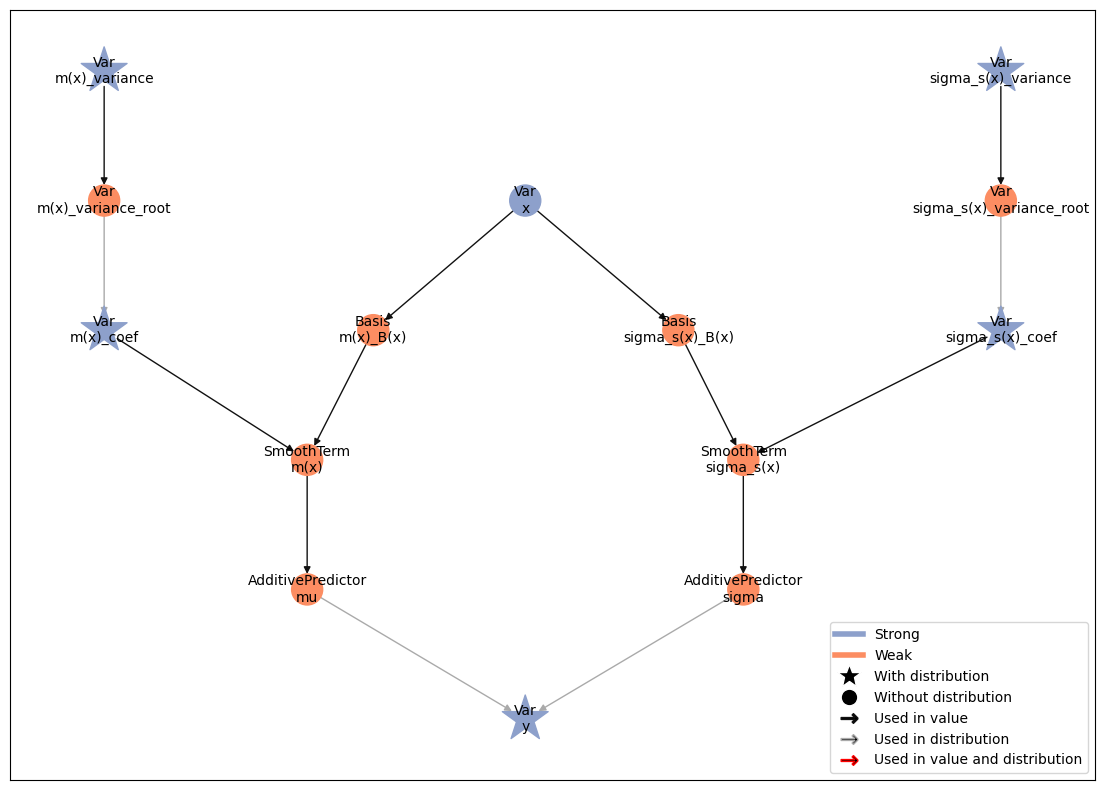

In [6]:
# Show available term keys for custom naming
print("Available term keys:", constructor.get_term_keys("s(x)"))
constructor = lgam.Constructor(df)
loc = constructor.predictor("s(x)", name="mu", term_names={"s(x)": "m(x)"})
scale = constructor.predictor("s(x)", name="sigma", inv_link=jnp.exp)
y = constructor.response("y", distribution=tfd.Normal, loc=loc, scale=scale)
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

The GAM constructor automatically sets up IWLS and Gibbs kernels for all parameters, making MCMC setup straightforward.

In [7]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'sigma_s(x)_coef', 'sigma_s(x)_variance', 'm(x)_coef', 'm(x)_variance'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:01<00:00,  8.63chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 366.99chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 0, 0, 1, 0 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:00, 404.21chu

### MCMC summary

In [8]:
summary = gs.Summary(results)
summary

Parameter summary:

                              kernel        mean          sd      q_0.05  \
parameter           index                                                  
m(x)_coef           (0,)   kernel_02   -8.096440    7.801053  -20.973153   
                    (1,)   kernel_02   -6.082139    7.471530  -18.581938   
                    (2,)   kernel_02   -2.652629    9.622054  -18.707570   
                    (3,)   kernel_02  -50.573959    4.162786  -57.402705   
                    (4,)   kernel_02   42.982613    4.605341   35.667749   
                    (5,)   kernel_02    3.767253    1.411116    1.388646   
                    (6,)   kernel_02    3.782574    1.200274    1.818207   
                    (7,)   kernel_02   -0.440499    2.260828   -4.136221   
                    (8,)   kernel_02   45.531578    5.106463   36.987994   
m(x)_variance       ()     kernel_03  792.356506  523.750732  299.592139   
sigma_s(x)_coef     (0,)   kernel_00    0.013474    3.612513   -5.875993   
                    (1,)   kernel_00    0.924388    3.299560   -4.099598   
                    (2,)   kernel_00    0.505506    3.294579   -4.766843   
                    (3,)   kernel_00   -3.359418    2.946000   -8.634175   
                    (4,)   kernel_00    0.476237    2.614987   -3.746150   
                    (5,)   kernel_00    4.864840    1.453243    2.586825   
                    (6,)   kernel_00    0.088386    1.369602   -2.175690   
                    (7,)   kernel_00    0.825960    2.098939   -2.380738   
                    (8,)   kernel_00    3.093883    4.946519   -4.562270   
sigma_s(x)_variance ()     kernel_01   15.994851   19.169598    2.393563   

                                q_0.5       q_0.95  sample_size     ess_bulk  \
parameter           index                                                      
m(x)_coef           (0,)    -8.114441     4.708108         4000  3362.974707   
                    (1,)    -5.946286     6.165660         4000  2660.493038   
                    (2,)    -2.495831    13.253230         4000  3390.421926   
                    (3,)   -50.568756   -43.637842         4000  2293.771887   
                    (4,)    43.006250    50.609434         4000  3206.527131   
                    (5,)     3.810044     6.041766         4000  2553.877061   
                    (6,)     3.767069     5.740024         4000  2919.605692   
                    (7,)    -0.398769     3.209979         4000  3507.518156   
                    (8,)    45.485899    53.778855         4000  3274.043937   
m(x)_variance       ()     652.727814  1757.402350         4000  3990.281476   
sigma_s(x)_coef     (0,)    -0.060915     6.029464         4000  2475.298218   
                    (1,)     0.792466     6.572603         4000  2306.839695   
                    (2,)     0.410981     6.144549         4000  2299.243414   
                    (3,)    -2.973126     0.743733         4000  1421.268731   
                    (4,)     0.369488     4.985328         4000  2230.710442   
                    (5,)     4.820233     7.425882         4000  1406.080190   
                    (6,)     0.078360     2.365779         4000  1984.951399   
                    (7,)     0.670476     4.472306         4000  1831.318053   
                    (8,)     3.002244    11.357618         4000  2108.245853   
sigma_s(x)_variance ()      10.780275    46.162665         4000  1477.415487   

                              ess_tail      rhat  
parameter           index                         
m(x)_coef           (0,)   3562.877579  1.000018  
                    (1,)   3738.927199  1.000416  
                    (2,)   3676.970210  0.999631  
                    (3,)   3191.640173  1.000482  
                    (4,)   3554.924548  1.000540  
                    (5,)   3378.104291  1.000317  
                    (6,)   3627.696883  1.000111  
                    (7,)   3489.050116  1.001295  
                    (8,)   3359.8522

### MCMC trace plots

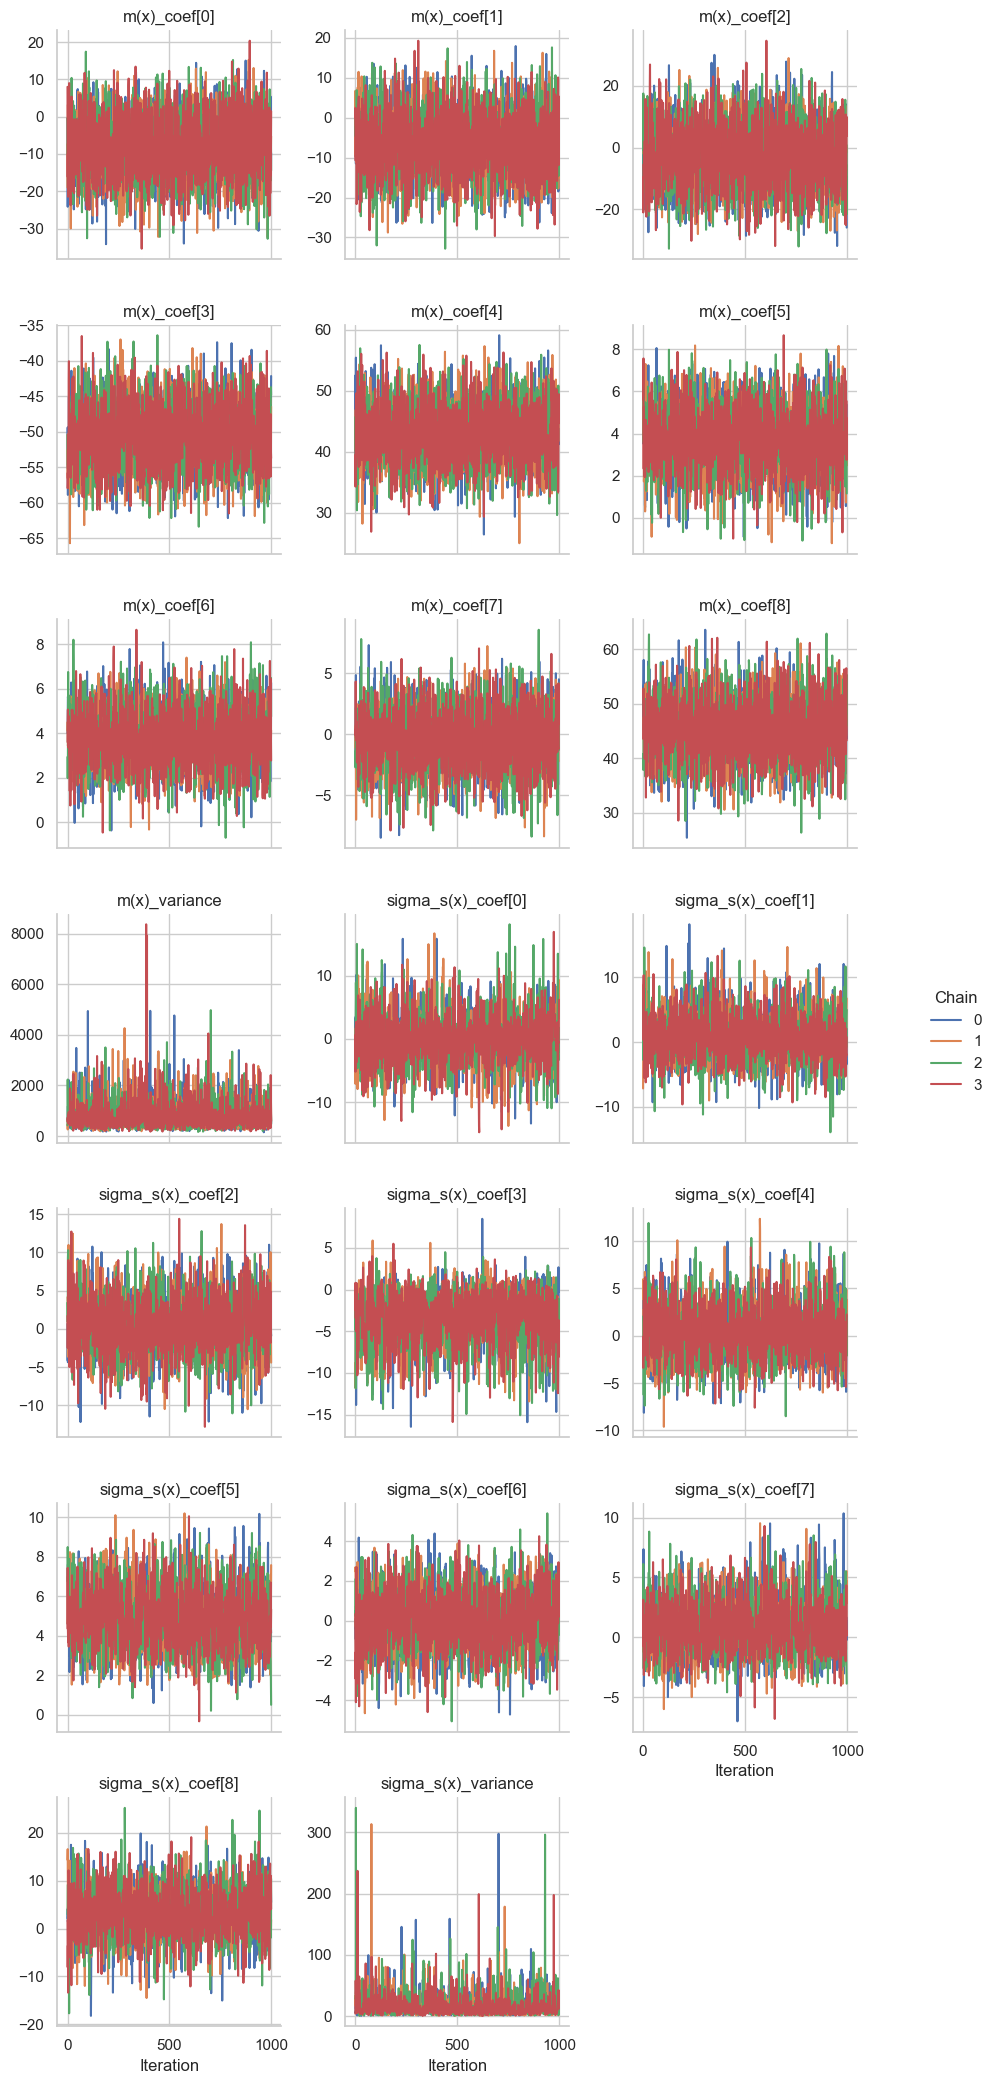

In [9]:
gs.plot_trace(results)

## Predictions

In [10]:
samples = results.get_posterior_samples()

### Prediction Grid

In [11]:
x_grid = jnp.linspace(x.min(), x.max(), 300)

### Model Predictions

In [12]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["m(x)", "sigma_s(x)", "mu", "sigma"],
    newdata={"x": x_grid},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["x"] = np.tile(x_grid, len(predictions))

In [13]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,m(x),m(x)[0],"(0,)",4000,2.236141,0.012495,0.111779,1.000578,3925.876056,3616.182360,0.001802,0.002762,2.075875,2.229810,2.418975,2.073437,2.415117,-1.976702
1,m(x),m(x)[1],"(1,)",4000,2.345697,0.011199,0.105825,1.000520,3917.988463,3616.239473,0.001708,0.002664,2.192309,2.339388,2.520498,2.176415,2.502197,-1.963415
2,m(x),m(x)[2],"(2,)",4000,2.455172,0.010029,0.100144,1.000511,3911.004004,3434.150932,0.001619,0.002566,2.311084,2.448622,2.619121,2.293349,2.601548,-1.950128
3,m(x),m(x)[3],"(3,)",4000,2.564475,0.008984,0.094787,1.000528,3904.771115,3610.100941,0.001536,0.002464,2.427697,2.558671,2.720894,2.425496,2.715055,-1.936841
4,m(x),m(x)[4],"(4,)",4000,2.673501,0.008066,0.089810,1.000421,3896.740305,3468.245803,0.001459,0.002360,2.543853,2.668038,2.820814,2.542275,2.814914,-1.923554


### Plot fitted functions

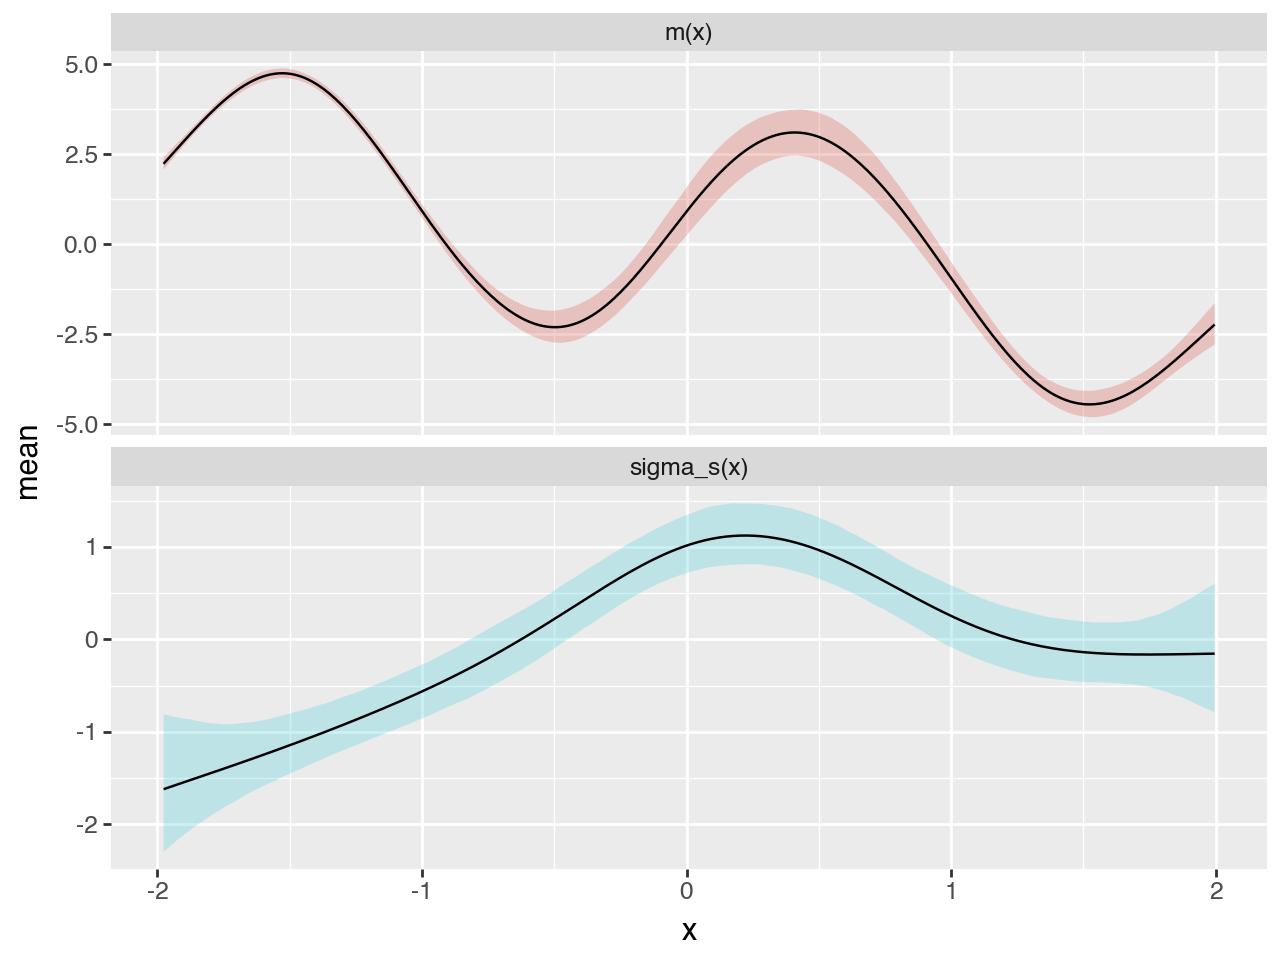

In [14]:
select = predictions_summary["variable"].isin(["m(x)", "sigma_s(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

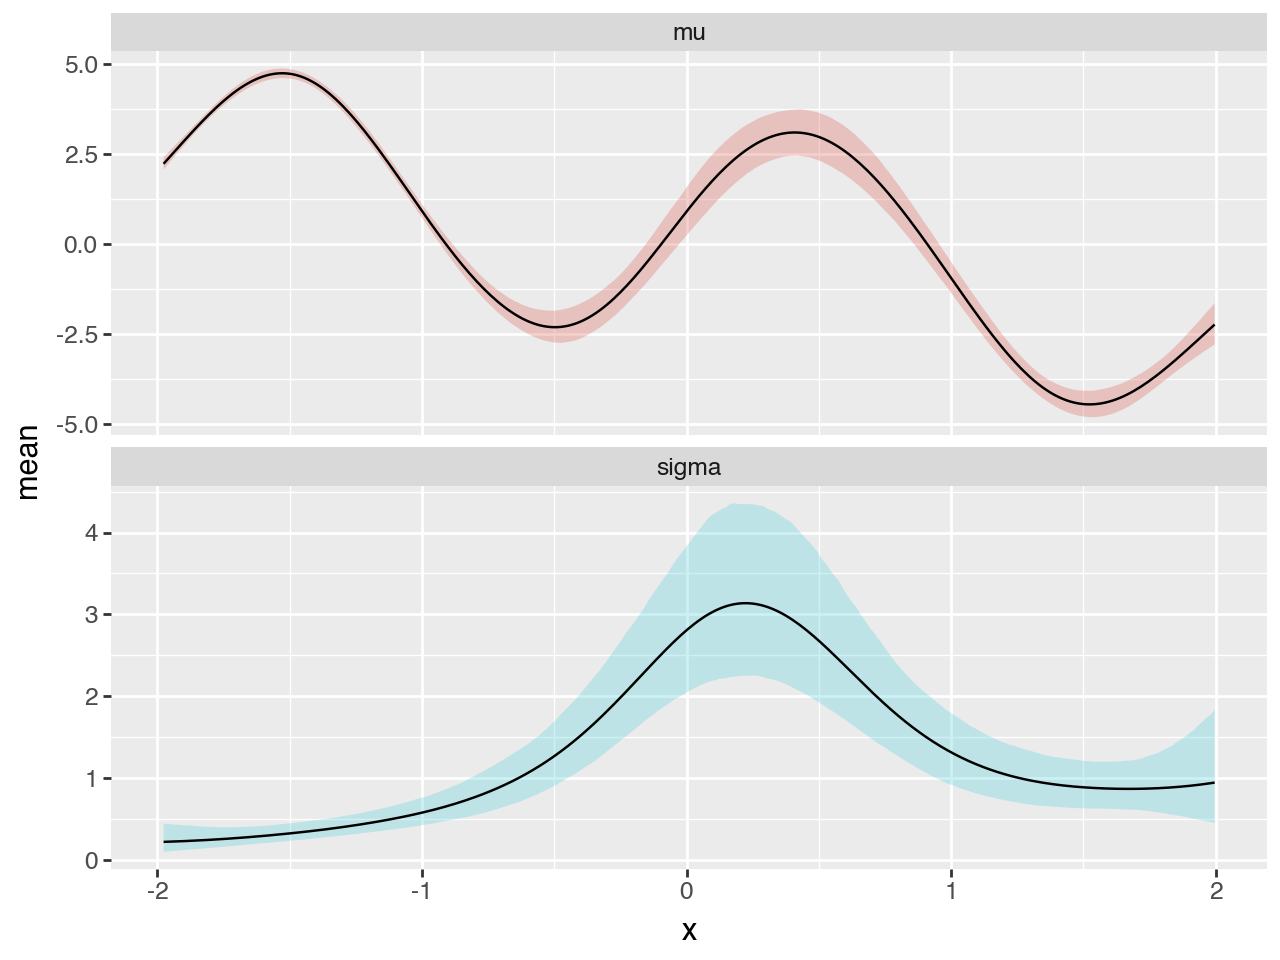

In [15]:
select = predictions_summary["variable"].isin(["mu", "sigma"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

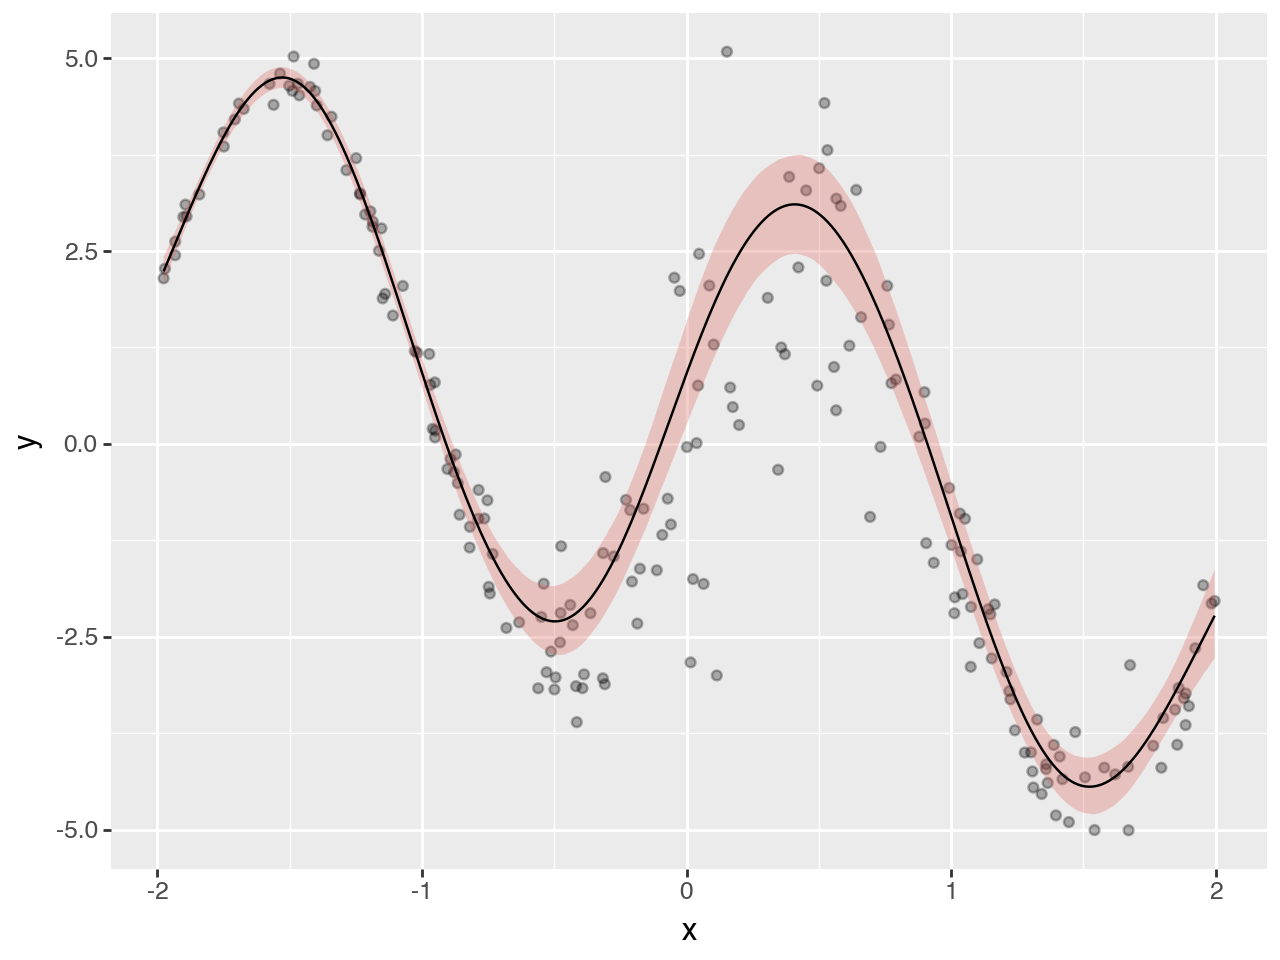

In [16]:
select = predictions_summary["variable"].isin(["mu"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [17]:
select = predictions_summary["variable"].isin(["mu", "sigma"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["mu"] - mu_sigma_df["sigma"]
mu_sigma_df["high"] = mu_sigma_df["mu"] + mu_sigma_df["sigma"]
mu_sigma_df

variable,x,mu,sigma,low,high
0,-1.976702,2.236141,0.221694,2.014447,2.457836
1,-1.963415,2.345697,0.223090,2.122608,2.568787
2,-1.950128,2.455172,0.224562,2.230610,2.679734
3,-1.936841,2.564475,0.226113,2.338362,2.790588
4,-1.923554,2.673501,0.227744,2.445756,2.901245
...,...,...,...,...,...
295,1.942956,-2.585885,0.921618,-3.507502,-1.664267
296,1.956243,-2.496283,0.927171,-3.423454,-1.569111
297,1.969530,-2.406506,0.933033,-3.339539,-1.473473
298,1.982817,-2.316614,0.939204,-3.255818,-1.377409


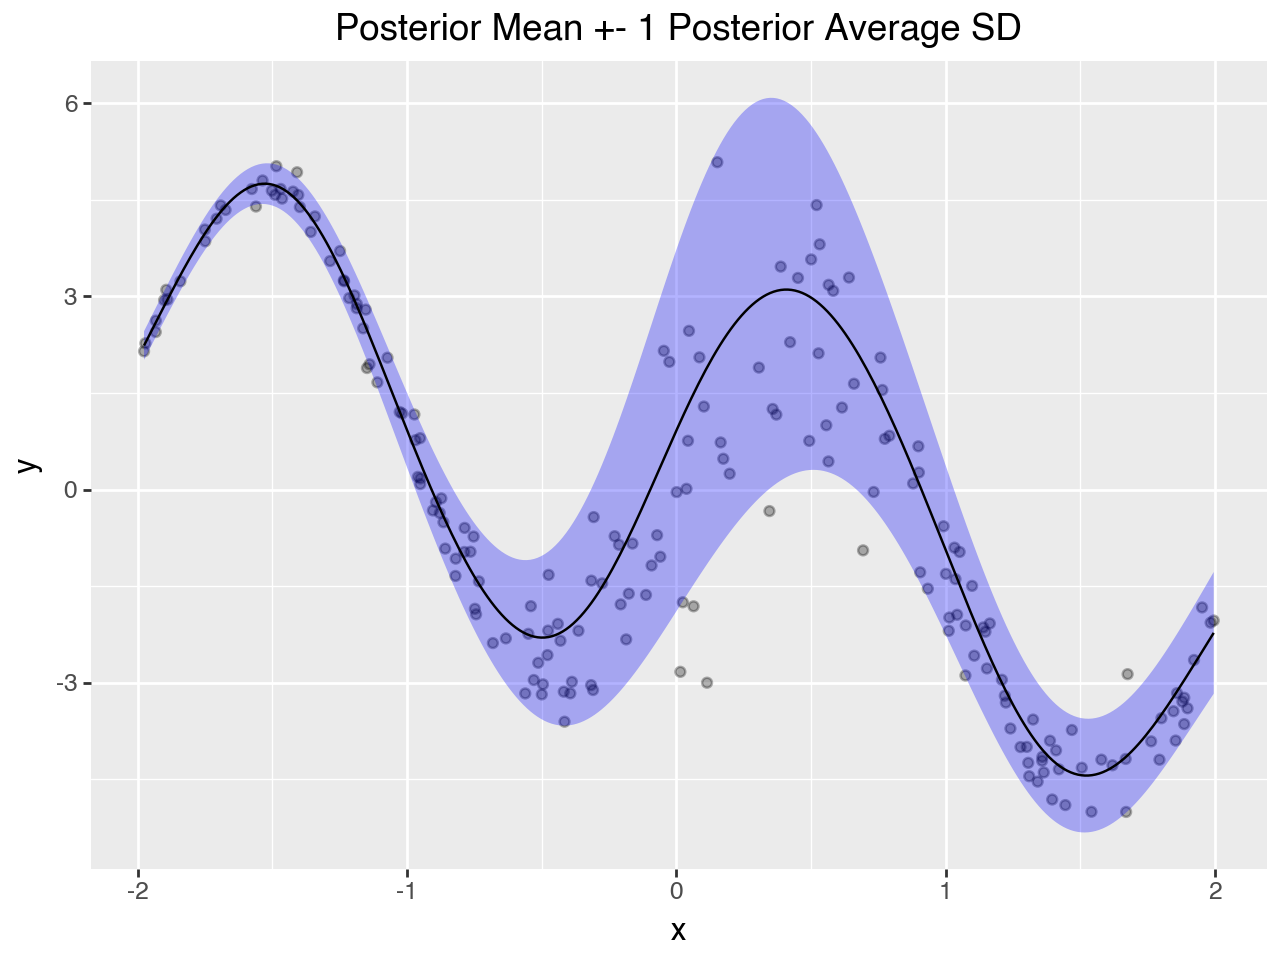

In [18]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "mu"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [19]:
ppsamples = model.sample(  # new in liesel v0.4.0
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["y"].shape

(3, 4, 1000, 200)

In [20]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])

### Summarize posterior predictive samples

In [21]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

### Plot posterior predictive summary

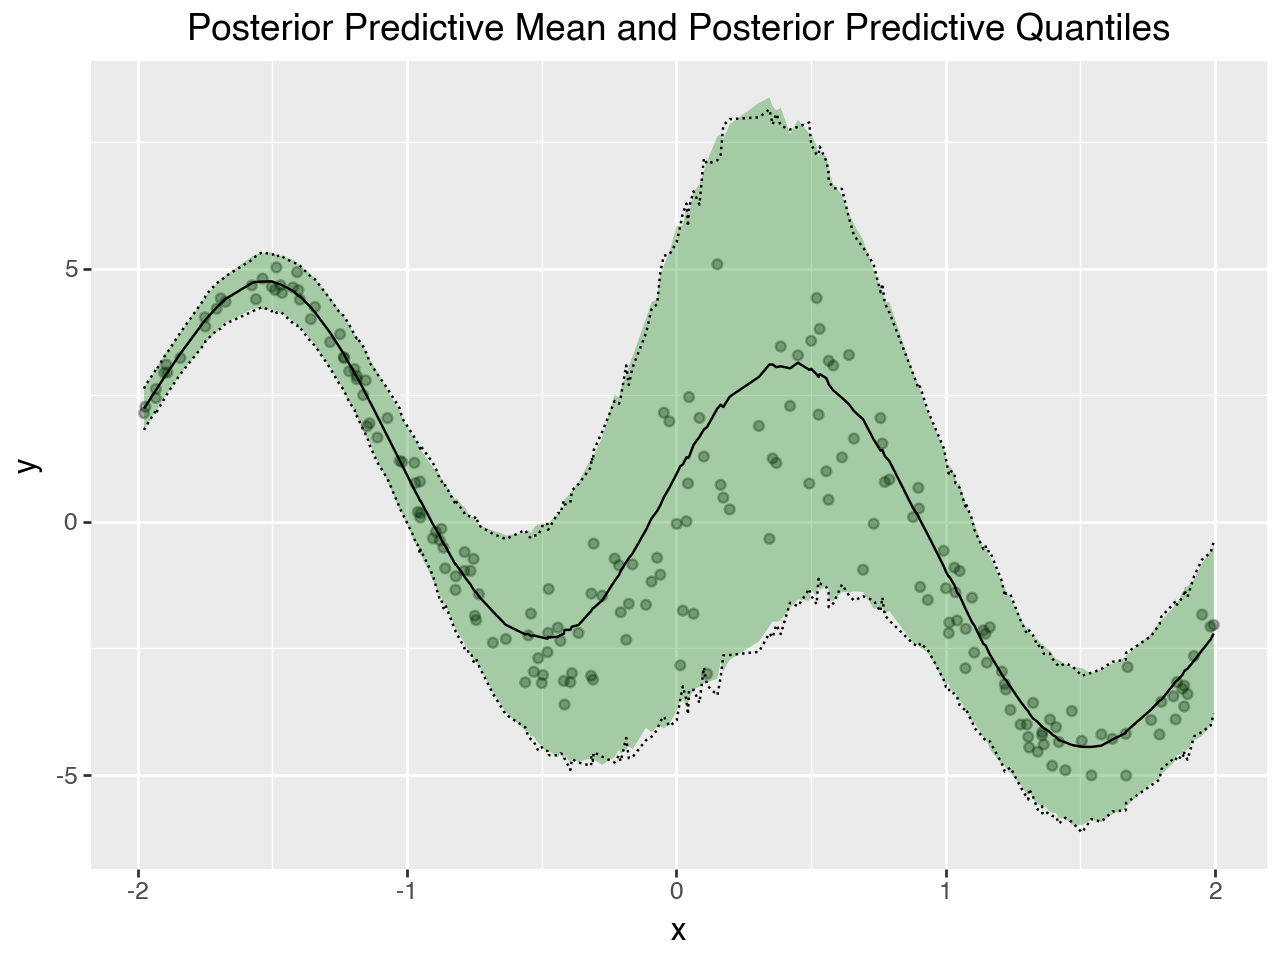

In [22]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

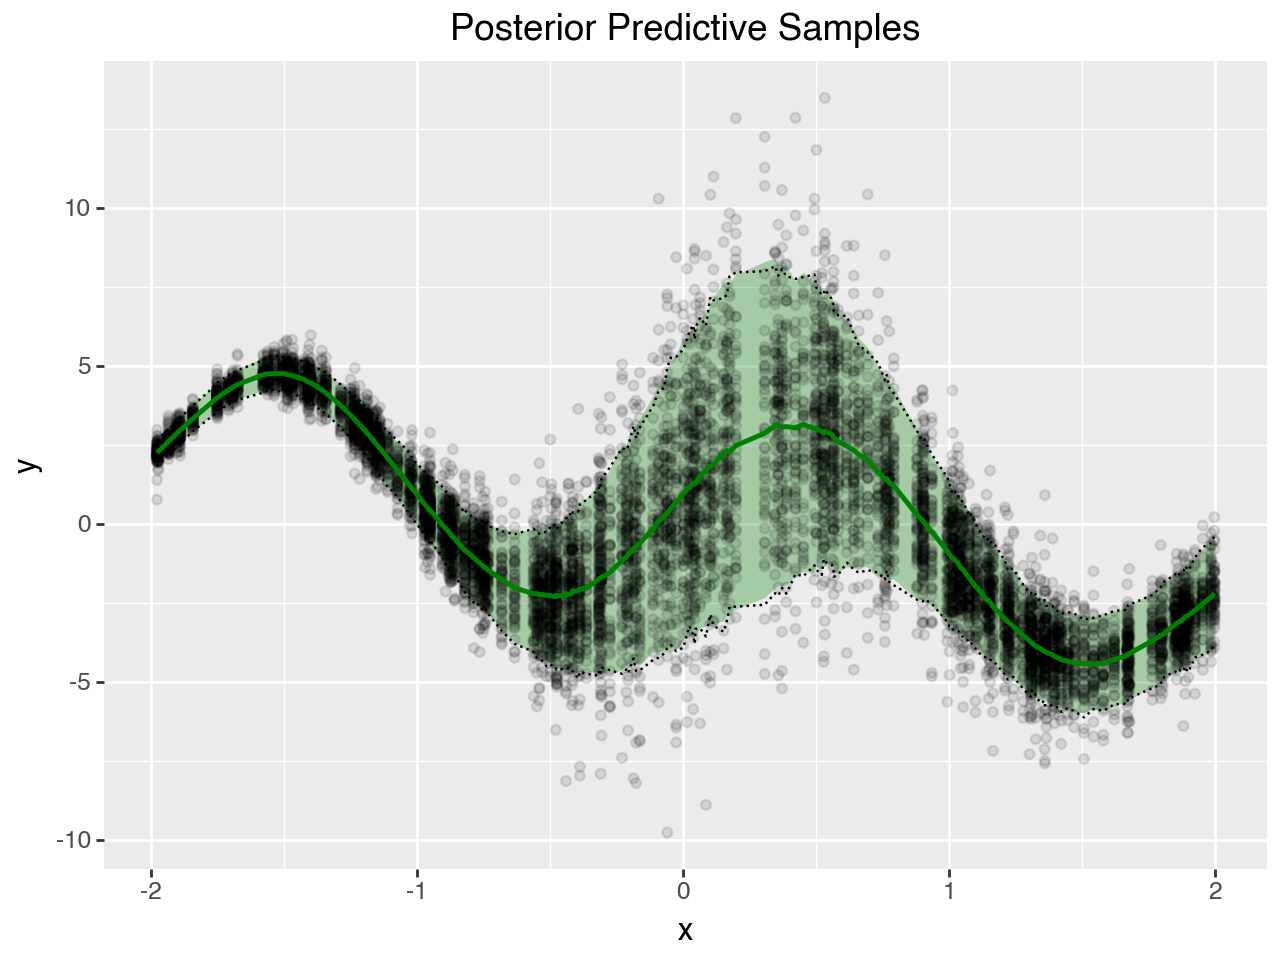

In [23]:
ppsamples_reshaped = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["x"] = df["x"].to_numpy()
ppsamples_df = ppsamples_df.melt(id_vars=["x"], value_name="y", var_name="sample")
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("x", "y"), alpha=0.1)
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "mean"), color="green", size=1, data=ppsamples_summary)
)